# Review Data EDA

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
sns.set()

In [2]:
def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text))

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib
font = {'size' : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)
DO_WRITE_CHARTS = True

# Load Review Data for Arizona Restaurants

In [4]:
time_marker(text='Loading Review Data...')

reviews = pd.DataFrame()
file_path_slug = '../clean_data/az_restaurant_reviews.csv'
file_list = glob(file_path_slug)

# Chunk Settings
chunks = list()
chunksize = 10000
for ii, file in enumerate(sorted(file_list)):
    time_marker('Reading {} of {} {}...'.format(ii+1, len(file_list), file))
    # import file in chunks
    for jj, chunk in enumerate(pd.read_csv(file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['date'])):
        
        # append chunk to chunks list
        chunks.append(chunk)
        
time_marker(text='merging to dataframe...')
reviews = pd.concat(chunks)

time_marker('reseting index...')
reviews.reset_index(inplace=True, drop=True)
time_marker(text='Complete!')


[22:50:08.715259] Loading Review Data...
[22:50:08.716958] Reading 1 of 1 ../clean_data/az_restaurant_reviews.csv...
[22:50:18.263989] merging to dataframe...
[22:50:19.405614] reseting index...
[22:50:19.415281] Complete!


In [5]:
time_marker('Dropping records with NaN values...')
reviews.dropna(how='any', inplace=True)
reviews.reset_index(inplace=True, drop=True)

time_marker('Cleaning data types...')
reviews['cool'] = reviews['cool'].astype('int')
reviews['funny'] = reviews['funny'].astype('int')
reviews['stars'] = reviews['stars'].astype('int')
reviews['useful'] = reviews['useful'].astype('int')
reviews['review_len'] = reviews['review_len'].astype('int')
reviews['is_fast_food'] = reviews['is_fast_food'].apply(lambda x: True if x == 1 else False)
reviews['date'] = pd.to_datetime(reviews['date'])

time_marker('assiging \'Positive\' or \'Negative\' classification to reviews...')
reviews['is_positive'] = reviews.stars.apply(lambda x: True if x > 3 else False)
           

[22:50:19.456404] Dropping records with NaN values...
[22:50:20.313006] Cleaning data types...
[22:50:20.867295] assiging 'Positive' or 'Negative' classification to reviews...


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495893 entries, 0 to 495892
Data columns (total 12 columns):
business_id     495893 non-null object
cool            495893 non-null int64
date            495893 non-null datetime64[ns]
funny           495893 non-null int64
review_id       495893 non-null object
stars           495893 non-null int64
text            495893 non-null object
useful          495893 non-null int64
user_id         495893 non-null object
is_fast_food    495893 non-null bool
review_len      495893 non-null int64
is_positive     495893 non-null bool
dtypes: bool(2), datetime64[ns](1), int64(5), object(4)
memory usage: 38.8+ MB


In [7]:
reviews.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,is_fast_food,review_len,is_positive
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,BF0ANB54sc_f-3_howQBCg,1,we always go to the chevo's in chandler which ...,3,ssuXFjkH4neiBgwv-oN4IA,False,422,False
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,DbLUpPT61ykLTakknCF9CQ,1,this place is always so dirty and grimy been t...,6,ssuXFjkH4neiBgwv-oN4IA,False,111,False
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,z_mVLygzPn8uHp63SSCErw,4,holy portion sizes! you get a lot of bang for ...,0,MzEnYCyZlRYQRISNMXTWIg,False,130,True


# Normalizing Review Text

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [9]:
# import stop words
stop_words = set(stopwords.words('english'))

# terms and characters to ignore, we dont care about punctuation
exclude = set(string.punctuation)

contractions = ["'s", "n't", "'ll", "'t", "'s", "'re"]

# lemma
lemma = WordNetLemmatizer()

exclusion_terms = list(set(set(stop_words) | set(exclude) | set(contractions)))

In [10]:
def clean_review(doc):
    ''' remove stop words, remove punctuation, and lemmatize a text document'''

    # lemmatize, tokenize and remove stop words, puncuation and contractions
    # remove non alpha tokens
    tokens = [lemma.lemmatize(word) for word in word_tokenize(doc) if word not in exclusion_terms and word.isalpha()]
    
    return tokens

# Prepare Review Corpus for LDA

In [11]:
from gensim.corpora.dictionary import Dictionary
from collections import defaultdict
import itertools

In [12]:
def lda_prep(corpus=None, n_terms=5):
    '''
    
        @ params:
            corpus   : a list of 
            n_terms  : the number of top terms to preview to the console
    
        returns:
            a list of 3 items
                dictionary        :  a gensim dictionary object built from the corpus
                corpus            :  a bag of words sparce array of corpus terms
                total_word_count  :  a defaultdict with key word identifier in dictionary, and value the count of times that word appears in the corpus
    
    '''
    if corpus == None:
        return False  
    else:
        time_marker('building gensim dict...')
        # build gensim dict, key=token, value=count
        dictionary = Dictionary(corpus)
        # print('dictionary Tokens to ID {}'.format(dictionary.token2id))

        # create a gensim corpus
        time_marker('building gensim corpus...')
        corpus = [dictionary.doc2bow(doc) for doc in clean_docs]
        # print('gensim Corpus {}'.format(corpus[0]))

        # create a defaultdict
        total_word_count = defaultdict(int)

        # loop over corpus and count the number of times each word appears
        for word_id, word_count in itertools.chain.from_iterable(corpus):
            total_word_count[word_id] += word_count

        # create a sorted list from the defaultdict
        sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)

        # print top n_terms words across all documents
        print('Top {:d} words across all documents'.format(n_terms))
        for word_id, word_count in sorted_word_count[:n_terms]:
            print('{:20}{}'.format(dictionary.get(word_id), word_count))
        
        return [dictionary, corpus, total_word_count]

# Split up by `Fast Food` and `Non Fast Food` Restaurant Reviews

In [13]:
ff_reviews = reviews[reviews.is_fast_food == True].copy()
ff_reviews.reset_index(inplace=True, drop=True)
nff_reviews = reviews[reviews.is_fast_food == False].copy()
nff_reviews.reset_index(inplace=True, drop=True)

In [14]:
print('============================== Fast Food Reviews ==============================')
print('{:45}{:d}\t{:2.4f}'.format('Number of Fast Food Reviews', ff_reviews.shape[0], 100.*ff_reviews.shape[0] / reviews.shape[0]))
print('{:45}{:d}\t{:2.4f}'.format('Number of Positive Fast Food Reviews', ff_reviews[ff_reviews.is_positive == True].shape[0], (100.*ff_reviews[ff_reviews.is_positive == True].shape[0]/ff_reviews.shape[0])))
print('{:45}{:d}\t{:2.4f}'.format('Number of Negative Fast Food Reviews', ff_reviews[ff_reviews.is_positive == False].shape[0], (100.*ff_reviews[ff_reviews.is_positive == False].shape[0]/ff_reviews.shape[0])))

print()
print('============================ Non Fast Food Reviews ============================')
print('{:45}{:d}\t{:2.4f}'.format('Number of Non Fast Food Reviews', nff_reviews.shape[0], 100.*nff_reviews.shape[0] / reviews.shape[0]))
print('{:45}{:d}\t{:2.4f}'.format('Number of Positive Non Fast Food Reviews', nff_reviews[nff_reviews.is_positive == True].shape[0], (100.*nff_reviews[nff_reviews.is_positive == True].shape[0]/nff_reviews.shape[0])))
print('{:45}{:d}\t{:2.4f}'.format('Number of Negative Non Fast Food Reviews', nff_reviews[nff_reviews.is_positive == False].shape[0], (100.*nff_reviews[nff_reviews.is_positive == False].shape[0]/nff_reviews.shape[0])))

============================== Fast Food Reviews ==============================
Number of Fast Food Reviews                  39907	8.0475
Number of Positive Fast Food Reviews         19488	48.8335
Number of Negative Fast Food Reviews         20419	51.1665

============================ Non Fast Food Reviews ============================
Number of Non Fast Food Reviews              455986	91.9525
Number of Positive Non Fast Food Reviews     303285	66.5119
Number of Negative Non Fast Food Reviews     152701	33.4881


# Fast Food Reviews

<p><b>Step 1: </b>Subset to only evaluate `Fast Food` Reviews</p>

In [15]:
ff_reviews.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,is_fast_food,review_len,is_positive
0,iIjVO7cLD1UEmIO7G05Ujw,0,2016-06-11,0,xatycgntu_F_Ioyny3iflw,4,flavor was actually pretty good. not used to e...,0,vaXJ7-xLrnD6FAEhUqYKwQ,True,309,True
1,8F-CalsRSKiPjjsx8ql8Lg,9,2009-12-22,8,xWvUUQ-tO-x9pAsG8JEnOQ,4,i really want to give this place four stars. g...,6,dyhTHLIf6eWBvU78Y3T06A,True,2349,True
2,tOUFYUVuhdvtHVSrYu2hwA,1,2011-05-07,3,uDzIp-k19kdAYM3Az9PYMw,3,i know. you are reading this and wanting to ri...,1,5V8eXkTJb6IejJkMDaj_Bw,True,598,False


In [16]:
ff_reviews.shape[0]

39907

<p><b>Step 2: </b>Tokenize and Normalize review text</p>

In [17]:
time_marker('tokenizing and normalizing text...')
ff_reviews['tokens'] = ff_reviews.text.apply(lambda r: clean_review(r))
ff_reviews['norm_text'] = ff_reviews.tokens.apply(lambda t: ' '.join(t))
time_marker('done!')

[22:50:24.400117] tokenizing and normalizing text...
[22:51:48.035937] done!


# Strip down to top 10,000 most frequent tokens
<p>WEll not exactly top 10,000 keep terms that appear more frequently than the 10,000th term does.</p>

In [18]:
from collections import Counter

In [19]:
token_lists = list(ff_reviews['tokens'].values)
flat_list = [item for sublist in token_lists for item in sublist]
token_counter = Counter(flat_list)

NameError: name 'term_keep_count' is not defined

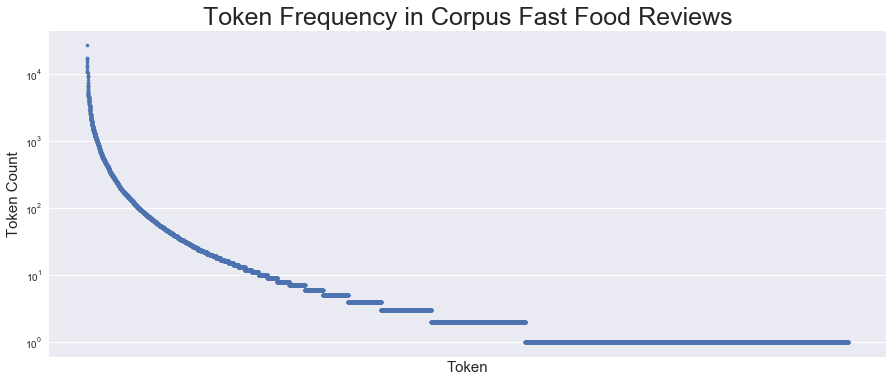

In [20]:
term_keep_count_min = 10000

title_text = 'Fast Food Reviews'

df = pd.DataFrame.from_dict(token_counter, orient='index').reset_index()
df.columns = ['token', 'token_count']
df.sort_values('token_count', ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)

ax = df['token_count'].plot(logy=True, figsize=FIG_SIZE, marker='.', linestyle='')
ax.set_title('Token Frequency in Corpus {}'.format(title_text.title()), size=TITLE_FONT_SIZE)
ax.set_xlabel('Token', size=LABEL_FONT_SIZE)
ax.set_ylabel('Token Count', size=LABEL_FONT_SIZE)
ax.set_xticks([])

# cutoff lines
ax.axvline(term_keep_count)
ax.axhline(df.iloc[term_keep_count,1])

if DO_WRITE_CHARTS:
    plt.savefig('../charts/token_dist/tokens_count_curve_{}.png'.format(title_text.lower().replace(' ', '_')))
else:
    plt.show()
plt.close()
    
# going to drop tokens that appear fewer than 4 times
print('{:30}{:d}'.format('Original Unique Token Count', df.shape[0]))
print('{:30}{:d}'.format('Pruned Token Count', df[df.token_count > df.iloc[term_keep_count_min,1]].shape[0]))

tokens_to_keep = list(df[df.token_count > df.iloc[term_keep_count_min,1]].token.values)

## Prune tokens not found in `tokens_to_keep`

In [ ]:
ff_reviews['tokens_keep'] = ff_reviews['tokens'].apply(lambda token_list: [token for token in token_list if token in tokens_to_keep])

In [ ]:
def plot_token_changes(df, title_text):

    diffs = df[df.tokens.str.len() != df.tokens_keep.str.len()].copy()
    origs = df[df.tokens.str.len() == df.tokens_keep.str.len()].copy()

    plt.subplots(figsize=(10, 10))
    plt.scatter(x=diffs.tokens.str.len(), y=diffs.tokens_keep.str.len(), color='b')
    plt.scatter(x=origs.tokens.str.len(), y=origs.tokens_keep.str.len(), color='g', alpha=0.5)

    plt.legend(['Token Count Changed', 'All Tokens Kept'], frameon=True, loc=2)
    plt.title('Token Count Changes {}'.format(title_text.title()), size=TITLE_FONT_SIZE)
    plt.xlabel('Original Tokens Count', size=LABEL_FONT_SIZE)
    plt.ylabel('Cleaned Tokens Count', size=LABEL_FONT_SIZE)

    if DO_WRITE_CHARTS:
        plt.savefig('../charts/token_dist/tokens_lost_diff_{}.png'.format(title_text.lower().replace(' ', '_')))
    else:
        plt.show()
    plt.close()



    plt.subplots(figsize=FIG_SIZE)
    df['tokens_lost'] = df.tokens.str.len() - df.tokens_keep.str.len() 

    df.tokens_lost.plot.hist(color='r')
    plt.title('Lost Token Distribution {}'.format(title_text.title()), size=TITLE_FONT_SIZE)
    plt.xlabel('Number of Tokens Removed', size=LABEL_FONT_SIZE)
    plt.ylabel('Frequency', size=LABEL_FONT_SIZE)
    
    if DO_WRITE_CHARTS:
        plt.savefig('../charts/token_dist/tokens_lost_dist_{}.png'.format(title_text.lower().replace(' ', '_')))
    else:
        plt.show()
    plt.close()
    
    return df

ff_reviews = plot_token_changes(ff_reviews, 'TEST Reviews')

In [ ]:
ff_reviews.head(3).transpose()

<p><b>Step 3: </b>Build our term dictionary, document term matrix, and preview the most common terms</p>

In [ ]:
# collect all cleaned review strings into a list of strings
clean_docs = list(ff_reviews.tokens_keep.values)

# create dictionary, corpus, and word counts with custom function
dictionary, doc_term_matrix, total_word_count = lda_prep(corpus=clean_docs, n_terms=25)

<p><b>Step 4: </b>Using a Multicore LDA model, attempt to identify topics from the dictionary</p>

In [ ]:
from gensim.models.ldamulticore import LdaMulticore
ldam = LdaMulticore

num_topics = 50
num_words  = 10
num_passes = 50

In [ ]:
time_marker('started generating lda multicore model')
ldam_model = ldam(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=num_passes)
time_marker('done!')

results = ldam_model.print_topics(num_topics=num_topics, num_words=num_words)

<p><b>Step 6: </b>View Results</p>

# Print Model Terms

In [ ]:
def print_topic_terms(model, num_topics=num_topics, num_words=10, unique=False):
    results = model.print_topics(num_topics=num_topics, num_words=num_words)
    if not unique:
        print('=============================== Terms Per Topic ===============================')
        for r in results:
            topic = r[0]
            term_list = r[1]

            term_list = term_list.split('"')[1::2]
            topic_terms = [term for term in term_list]
            print('{}\t{}'.format(topic, topic_terms))
    else:
        terms = [x[1] for x in results]
        term_lists = [x.split('"')[1::2] for x in terms]

        flatList = itertools.chain.from_iterable(term_lists)
        term_counts = Counter(flatList)

        # non_unique_terms = term_counts
        test = dict(term_counts)

        # extract terms that appear more than once
        non_unique_terms = [key for key, value in test.items() if value > 1]
        
        
        print('============================ Unique Terms Per Topic ===========================')
        for r in results:
            topic = r[0]
            term_list = r[1]

            term_list = term_list.split('"')[1::2]
            topic_terms = [term for term in term_list if term not in non_unique_terms]
            print('{}\t{}'.format(topic, topic_terms))

In [ ]:
print_topic_terms(ldam_model, num_topics=num_topics, num_words=10, unique=False)

In [ ]:
print_topic_terms(ldam_model, num_topics=num_topics, num_words=10, unique=True)

# Save Model

In [ ]:
# save model to disk (no need to use pickle module)
term = 'fast_food'
file_suffix = '{}_{:d}_topics_{:d}_terms_{}_passes'.format(term, num_topics, num_words, num_passes)
ldam_model.save('../models/ldam_{}.model'.format(file_suffix))

In [ ]:
time_marker('Done!')